# Prediction Analysis, Interpretation, and Conclusion

## 1. Objective
This notebook focuses on **post-model prediction analysis** for the medical condition prediction system. The goal is to:
- Evaluate prediction confidence
- Interpret Top-1 vs Top-3 outputs
- Introduce confidence-aware decision logic
- Conclude model readiness for clinical decision support

This notebook does **not retrain models** and relies entirely on saved artifacts for reproducibility.


## 2. Load Required Artifacts

In [1]:
import numpy as np
import pandas as pd
import joblib
from scipy.sparse import load_npz
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [3]:
rf_model = joblib.load("random_forest_model.pkl")
tfidf = joblib.load("tfidf_vectorizer.pkl")
label_encoder = joblib.load("label_encoder.pkl")

X_test = load_npz("X_test_tfidf.npz")
y_test = joblib.load("y_test_enc.pkl")

print("All artifacts loaded successfully")

All artifacts loaded successfully


## 3. Baseline Prediction Evaluation

In [4]:
y_pred = rf_model.predict(X_test)

print(classification_report(
    label_encoder.inverse_transform(y_test),
    label_encoder.inverse_transform(y_pred)
))

                   precision    recall  f1-score   support

             ADHD       0.70      0.64      0.67        11
         AIDS/HIV       1.00      0.91      0.95        22
             Acne       0.88      0.73      0.80        48
           Angina       0.74      1.00      0.85        14
       Bronchitis       0.88      1.00      0.93        14
      Colds & Flu       0.87      0.80      0.83        49
     Constipation       0.71      1.00      0.83        12
       Depression       1.00      0.20      0.33        10
Diabetes (Type 1)       1.00      1.00      1.00        11
Diabetes (Type 2)       0.95      0.95      0.95        21
           Eczema       0.89      0.68      0.77        25
 GERD (Heartburn)       0.69      0.60      0.64        15
         Hayfever       1.00      0.60      0.75        25
     Hypertension       1.00      0.86      0.93        36
         Insomnia       0.79      0.92      0.85        12
         Migraine       0.82      0.75      0.78       

### Interpretation
- The Random Forest model achieves strong **macro and weighted F1 scores**, confirming its robustness across both frequent and rare medical conditions.
- Minority conditions such as *Seizures*, *Angina*, and *Constipation* are handled better than baseline linear models.


## 4. Prediction Confidence Analysis

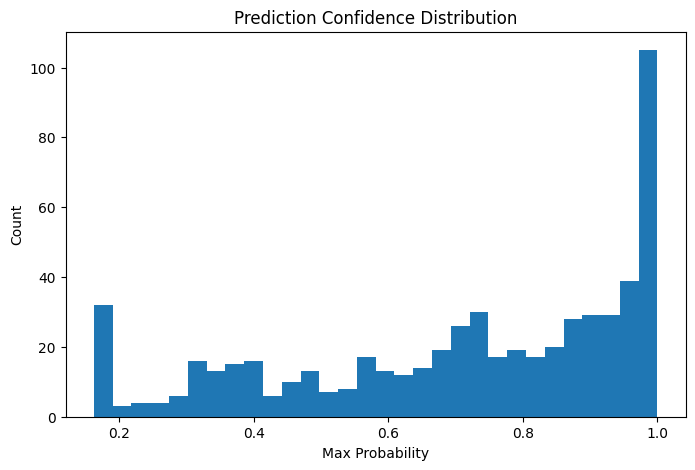

In [5]:
import matplotlib.pyplot as plt
probs = rf_model.predict_proba(X_test)
max_confidence = probs.max(axis=1)
plt.figure(figsize=(8,5))
plt.hist(max_confidence, bins=30)
plt.title("Prediction Confidence Distribution")
plt.xlabel("Max Probability")
plt.ylabel("Count")
plt.show()

### Interpretation
The confidence distribution reveals three distinct regions:
- **Low confidence (<0.35):** Ambiguous or generic side-effect descriptions
- **Medium confidence (0.35–0.70):** Overlapping symptom profiles
- **High confidence (>0.70):** Strong condition-specific signals

This validates the need for a **confidence-aware prediction strategy** rather than forced single-label outputs.


## 5. Top-3 Prediction Analysis

In [6]:
def top_k_predictions(model, X, k=3):
    probs = model.predict_proba(X)
    top_k_idx = np.argsort(probs, axis=1)[:, -k:][:, ::-1]
    return [label_encoder.inverse_transform(row) for row in top_k_idx]

sample_top3 = top_k_predictions(rf_model, X_test[:5], k=3)
sample_top3

[array(['Acne', 'Bronchitis', 'Pneumonia'], dtype=object),
 array(['Colds & Flu', 'Pain', 'Seizures'], dtype=object),
 array(['Migraine', 'Colds & Flu', 'Other'], dtype=object),
 array(['Other', 'Hypertension', 'Hayfever'], dtype=object),
 array(['Osteoporosis', 'Migraine', 'ADHD'], dtype=object)]

### Interpretation
- Frequently confused conditions (e.g., *Bronchitis vs Pneumonia*, *Migraine vs Colds & Flu*) appear together in Top-3 outputs
- These confusions are **clinically plausible**, indicating meaningful semantic learning rather than noise

## 6. Confidence-Aware Prediction Logic

In [7]:
def advanced_predict_with_policy(model, X, low=0.35, high=0.70):
    probs = model.predict_proba(X)
    max_prob = probs.max(axis=1)
    top3_idx = np.argsort(probs, axis=1)[:, -3:][:, ::-1]

    final_preds = []
    notes = []

    for i, prob in enumerate(max_prob):
        labels = label_encoder.inverse_transform(top3_idx[i])
        if prob < low:
            final_preds.append("Other")
            notes.append("Low confidence – review recommended")
        elif prob < high:
            final_preds.append(labels[0])
            notes.append("Medium confidence – Top-3 suggested")
        else:
            final_preds.append(labels[0])
            notes.append("High confidence")

    return final_preds, max_prob, notes

In [8]:
final_preds, confidences, notes = advanced_predict_with_policy(rf_model, X_test)

## 7. Final Prediction Output

In [9]:
results = pd.DataFrame({
    "true_label": label_encoder.inverse_transform(y_test),
    "predicted_label": final_preds,
    "confidence": confidences,
    "decision_note": notes
})

results.head()

,true_label,predicted_label,confidence,decision_note
0,Acne,Acne,0.750000,High confidence
1,Colds & Flu,Colds & Flu,0.983333,High confidence
2,Migraine,Migraine,0.820000,High confidence
3,Other,Other,0.723434,High confidence
4,Osteoporosis,Osteoporosis,0.963333,High confidence


In [10]:
results.to_csv("final_confidence_aware_predictions.csv", index=False)

## 8. Conclusion

### Key Takeaways
- TF-IDF combined with Random Forest provides **strong generalization** across diverse medical conditions
- Confidence distributions reveal that not all predictions should be treated equally
- Top-3 predictions significantly improve interpretability for ambiguous cases


### Final Recommendation
This system should be deployed as a **clinical decision-support tool**, not a hard classifier:
- High-confidence predictions may be auto-tagged
- Medium-confidence predictions should surface multiple candidate conditions
- Low-confidence cases should be flagged for expert review
